## load some stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy import units as u
from astropy import constants as const

import sys
sys.path.append('..')  # Add parent directory to the system path
sys.path.append('/home/montalvo/Pyspace/Scintillometry/Double_Pulsar')
# sys.path.append('/home/montalvo/Pyspace/Scintillometry/Double_Pulsar/Scintillometry/J0737-3039A-2021.par')


In [2]:
from pint.models import get_model
from RickettTables import fitvals
from RickettEquations import *
from Curvature import *

from matplotlib.colors import LogNorm, SymLogNorm

sys.path.append('/home/montalvo/Pyspace/Scintillometry/scint_dp')

from Funcs_DP import *
from Funcs_DP_Orbsim import *
from Funcs_DP_chi_measure import *
from Funcs_DP_simulator import *
from Aux_funcs import *
from screens_binary import *


In [3]:
par = 'J0737-3039A-2021.par'

psr_m = get_model('/home/montalvo/Pyspace/Scintillometry/scint_dp/J0737-3039A-2021.par')

psr = SkyCoord(ra=str(psr_m.RAJ.quantity), dec=str(psr_m.DECJ.quantity),
                   pm_ra_cosdec=psr_m.PMRA.quantity, pm_dec=psr_m.PMDEC.quantity)

def Eart_ad(mjd_t):
    
    #earth velocities in ra/dec in km/s but are unitless
    VE_a = EarthVelocity(t = Time(mjd_t,  format='mjd'), site = 'MeerKAT', psr = psr, rot = 0*u.deg)[1:3][0].value
    VE_dec = EarthVelocity(t = Time(mjd_t,  format='mjd'), site = 'MeerKAT', psr = psr, rot = 0*u.deg)[1:3][1].value
    
    return VE_a, VE_dec

def model_Ado(mjd_t, xi, Amp, C):
    
    #earth velocities in ra/dec in km/s but are unitless
    VE_a = EarthVelocity(t = Time(mjd_t,  format='mjd'), site = 'MeerKAT', psr = psr, rot = 0*u.deg)[1:3][0].value
    VE_dec = EarthVelocity(t = Time(mjd_t,  format='mjd'), site = 'MeerKAT', psr = psr, rot = 0*u.deg)[1:3][1].value
    
    A =   -Amp * ( VE_a * np.sin(xi) + VE_dec * np.cos(xi)  ) + C
    
    return A

def measurement_est( a_arr, da_arr):
    N = len( a_arr)
    w = 1 / da_arr**2
    w_avg = np.sum(a_arr * w) / np.sum(w)
    
    return w_avg, 1. / np.sqrt( np.sum(w) )


## loading the dynamic spectrum and other useful quantities (for observations after 2022-5-22)

In [4]:
#getting date and band
currentobs = '2023-5-16'     #you choose from the list of dates on the spreadsheet I sent you
band = 'S'                   #the band is given on the list

In [5]:
#NOTE: if the observation date on the spreadsheet contains "_re" add it to the path below just before npz. If there is no
#"_re", then don't add anything. This just selects the high resolution directory of the data (if it's available)

datpath = ('/fs/lustre/scratch/montalvo/meerkat_npz/bands/' 
           + band + '/' + currentobs 
           + '/inferred_data_' + currentobs + '_re.npz' )


data_tmp = np.load(datpath)


ts = data_tmp['time'] * u.hour
fs = data_tmp['freq'] * u.MHz
mjds = data_tmp['mjd']
phase = data_tmp['phase'] * u.rad
nu = data_tmp['nu'] * u.rad



#Earth velocity
ear_v = np.append( np.array( Eart_ad(mjds) ),  [0.]) * u.km/ u.s 

#loading freq and dynamic spec
fs_data = data_tmp['freq'] * u.MHz

#loading the dynamic spectrum that was divided by its svd model (not available for earlier than 2022-5-22)
ds_tmp = np.load(f'/fs/lustre/scratch/montalvo/meerkat_npz/bands/{band}/{currentobs}/svd_{currentobs}.npz')['dspec']

ds_tmp = data_tmp['dspec']



print( 'Date: ' ,currentobs, ', band = ', band)


#proper motion to velocity and pulsar distance
d_p = 0.697 * u.kpc
Va = (-2.567 * u.mas / u.year* d_p / u.rad).to( u.km / u.s )
Vd = ( 2.082 * u.mas / u.year* d_p / u.rad).to( u.km / u.s )


#getting the xi, A_M, C, and delta from the inferred values in the paper
mod_xi, mod_A2, mod_C, delta = model_returner_delta(dp = d_p, 
                                                   ds= 0.224 * u.kpc , 
                                                   xi = 77.05 * u.deg  , 
                                                   omp = 58.76 * u.deg,  
                                                   vism = -17.32 * u.km / u.s , 
                                                   inc = 90.65 * u.deg, 
                                                   vpa = Va, 
                                                   vpd = Vd)

#function to get xi, A2 and C params to spit out A
A_model = model_Ado(mjd_t = mjds, xi = mod_xi, Amp= mod_A2, C= mod_C)

print("A = ", d2str(A_model, 3) +  " delta = " + d2str(delta,3) + " (rad)" )

Date:  2023-5-16 , band =  S
A =  -0.171 delta = -0.004 (rad)


In [6]:
#select your frequency arrays
kif, kff = 2000, 5000

ds = ds_tmp[kif: kff]
fs = fs_data[kif: kff]

print('Frequency used: ' + d2str(fs[0].value,1) +  ' - ' + d2str(fs[-1].value,1) +  ' MHz')


Frequency used: 1856.4 - 2016.6 MHz


## Actual resampler 

In [7]:
#note: here the delta part has a +pi because there is a degeneracy with the vism sign and the orientation angle (as in
#I can always choose another vism and another ism angle and get the same. I just chose the sign that lets me keep 
#the values I extracted of A with the +pi. 
#you can always do 
# remap curve = A* t / Pb  +  f(v) *  cos(phi + delta) 
#OR
# remap curve = -A * t / Pb + f(v) * cos(phi + delta + pi)
res_pos, res_dyn, res_kd, res_CS, res_tau = resampler_dimensionless( A = A_model , 
                                                                          delta = delta + np.pi, 
                                                                          nu = nu, 
                                                                          phase = phase, 
                                                                          time = ts.value, 
                                                                          dyns = ds, 
                                                                          freq = fs, 
                                                                          Nres = 1000 )


#getting the times of the turning points for a given model of a screen's A and delta
a_guess = ts[ find_zero_crossings_indices(np.gradient( ts, Ad_projection_unitless(t = ts.value, 
                                nu = nu, 
                                phase = phase, 
                                A = A_model, 
                                delta = delta + np.pi) ) ) ].value

## Plot the two dynamic spectra

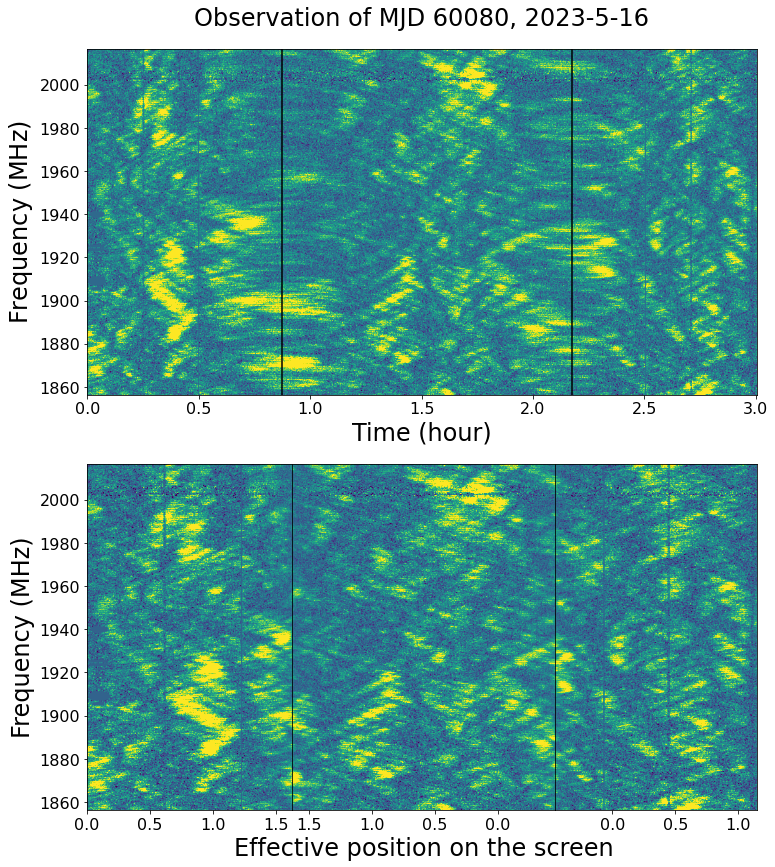

In [8]:
import matplotlib.gridspec as gridspec

def resamp_vis_combined(res_pos_u, res_dyn_u, fs_u, ds, ts, fs, std_fac=3., currentobs="", mjds=None, a_guess=None):
    relative_widths = [np.abs(x[0] - x[-1]).value for x in res_pos_u]
    total_width = sum(relative_widths)
    relative_widths = [width / total_width for width in relative_widths]

    fig = plt.figure(figsize=(sum(relative_widths) * 12, 14))

    # Set up a 2-row grid: 1 top row for main plot, 1 bottom row for res_dyn
    gs = gridspec.GridSpec(nrows=2, ncols=len(res_pos_u), height_ratios=[1, 1], 
                           width_ratios=relative_widths, hspace=0.2, wspace=0)

    # Top plot (main image across all columns)
    ax_top = fig.add_subplot(gs[0, :])
    im_top = ax_top.imshow(ds,
                           origin='lower', aspect='auto', 
                           extent=axis_extent(ts) + axis_extent(fs),
                           vmin=np.mean(ds) - std_fac * np.std(ds),
                           vmax=np.mean(ds) + std_fac * np.std(ds))
    ax_top.set_ylabel(rf"Frequency ({fs.unit.to_string('latex')})", fontsize=24)
    ax_top.set_xlabel(rf"Time (hour)", fontsize=24)
    ax_top.set_title(f'Observation of MJD {d2str(mjds,0)}, {currentobs}', fontsize=24, y=1.05)
    ax_top.tick_params(axis='both', which='major', labelsize=16)

    if a_guess is not None:
        for i in range(len(a_guess)):
            ax_top.axvline(x=a_guess[i], c='k')

    # Bottom subplots
    for i, (x, ax_pos) in enumerate(zip(res_pos_u, range(len(res_pos_u)))):
        ax = fig.add_subplot(gs[1, ax_pos])
        im = ax.imshow(res_dyn_u[i],
                       origin='lower', aspect='auto', 
                       extent=ext_find(res_pos_u[i], fs_u),
                       vmin=np.nanmean(res_dyn_u[0]) - std_fac * np.nanstd(res_dyn_u[0]),
                       vmax=np.nanmean(res_dyn_u[0]) + std_fac * np.nanstd(res_dyn_u[0]))

        ax.tick_params(axis='both', which='major', labelsize=16)
        if i == 0:
            ax.set_ylabel('Frequency (MHz)', fontsize=24)
        else:
            ax.set_yticks([])

        if i == len(res_pos_u) // 2:
            ax.set_xlabel('Effective position on the screen', fontsize=24)

#     plt.tight_layout()
    
    plt.show()
    
resamp_vis_combined(res_pos, res_dyn, fs, ds, ts, fs, std_fac=1, currentobs= currentobs, mjds=mjds, a_guess=a_guess)


## plot the resampled sec spectra

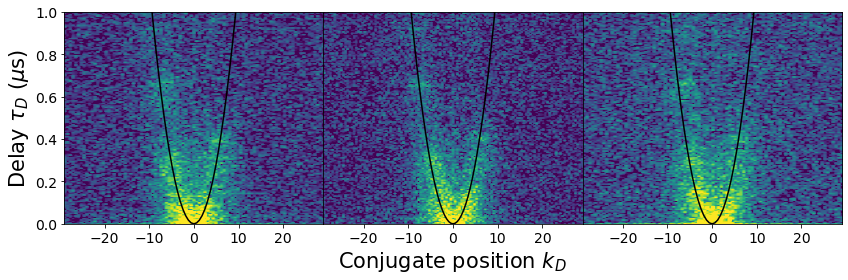

In [9]:
scalemin = 2e-6
scalemax = 1e-3
taulim = 1.
# tth_lim = 4
kdlimit = 29


#value of the resampled curvature (equivalent to Eq 29 times frequency squared)
#this is the measured value from table 1, or can also do 
# curv_constant = deff * const.c / 2 / B**2
curv_constant = 0.0427 * u.us * u.GHz**2
eta_2_use = (curv_constant / np.mean(fs)**2 )



plt.figure(figsize = (12,4))

#looping over the different regions
for i in range(len(res_dyn)):
    plt.subplot(1, len(res_dyn), i+1)
    plt.tight_layout()
    
    if i == 0:
        ylabels = 'Delay $\\tau_D$ ($\mu$s)'
        plt.ylabel(ylabels, fontsize = 21)
    else:
        ylabels = None
        plt.subplots_adjust(wspace=0, hspace=0.35)
        plt.yticks([])
    if i == 1:
        plt.xlabel('Conjugate position $k_D$ ', fontsize = 21)
        
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    #normalizing to the max of the observation (just for display purposes)
    kds, taus, css = res_kd[i], res_tau.to(u.us), res_CS[i]
    SS = np.abs(css)**2 
    SS /= np.max(SS)
    
    #plotting secondary spectra
    plt.imshow(SS, 
       norm=LogNorm(vmin= scalemin,vmax=scalemax ), 
       origin='lower',
       aspect='auto',
       
       extent=ext_find( kds, taus ))
    plt.ylim(0, taulim)
    plt.xlim((- kdlimit , kdlimit))
    
    #plot curvature
    plt.plot( kds, ((kds)**2 * eta_2_use).to(u.us), c = 'k')

plt.show()



## Example on 2022-04-26

In [10]:
#getting date and band
currentobs = '2022-4-26'     #you choose from the list of dates on the spreadsheet I sent you
band = 'L'                   #the band is given on the list

In [11]:
datpath = '/fs/lustre/scratch/montalvo/meerkat_npz/bands/' + band + '/' + currentobs + '/inferred_data_' + currentobs + '.npz'
data_tmp = np.load(datpath)


ts = data_tmp['time'] * u.hour
fs = data_tmp['freq'] * u.MHz
mjds = data_tmp['mjd']
phase = data_tmp['phase'] * u.rad
nu = data_tmp['nu'] * u.rad



#Earth velocity
ear_v = np.append( np.array( Eart_ad(mjds) ),  [0.]) * u.km/ u.s 

#loading freq and dynamic spec
fs_data = data_tmp['freq'] * u.MHz

#loading the dynamic spectrum that was divided by its svd model (not available for earlier than 2022-5-22)
ds_tmp = data_tmp['dspec']



print( 'Date: ' ,currentobs, ', band = ', band)


#proper motion to velocity and pulsar distance
d_p = 0.697 * u.kpc
Va = (-2.567 * u.mas / u.year* d_p / u.rad).to( u.km / u.s )
Vd = ( 2.082 * u.mas / u.year* d_p / u.rad).to( u.km / u.s )


#getting the xi, A_M, C, and delta from the inferred values in the paper
mod_xi, mod_A2, mod_C, delta = model_returner_delta(dp = d_p, 
                                                   ds= 0.224 * u.kpc , 
                                                   xi = 77.05 * u.deg  , 
                                                   omp = 58.76 * u.deg,  
                                                   vism = -17.32 * u.km / u.s , 
                                                   inc = 90.65 * u.deg, 
                                                   vpa = Va, 
                                                   vpd = Vd)

#function to get xi, A2 and C params to spit out A
A_model = model_Ado(mjd_t = mjds, xi = mod_xi, Amp= mod_A2, C= mod_C)

print("A = ", d2str(A_model, 3) +  " delta = " + d2str(delta,3) + " (rad)" )

Date:  2022-4-26 , band =  L
A =  -0.535 delta = -0.004 (rad)


In [12]:
#select your frequency arrays
kif, kff = 500, -1

ds = ds_tmp[kif: kff]
fs = fs_data[kif: kff]

print('Frequency used: ' + d2str(fs[0].value,1) +  ' - ' + d2str(fs[-1].value,1) +  ' MHz')


Frequency used: 1274.0 - 1710.3 MHz


In [13]:
res_pos, res_dyn, res_kd, res_CS, res_tau = resampler_dimensionless( A = A_model , 
                                                                          delta = delta + np.pi, 
                                                                          nu = nu, 
                                                                          phase = phase, 
                                                                          time = ts.value, 
                                                                          dyns = ds, 
                                                                          freq = fs, 
                                                                          Nres = 1000 )


#getting the times of the turning points for a given model of a screen's A and delta
a_guess = ts[ find_zero_crossings_indices(np.gradient( ts, Ad_projection_unitless(t = ts.value, 
                                nu = nu, 
                                phase = phase, 
                                A = A_model, 
                                delta = delta + np.pi) ) ) ].value

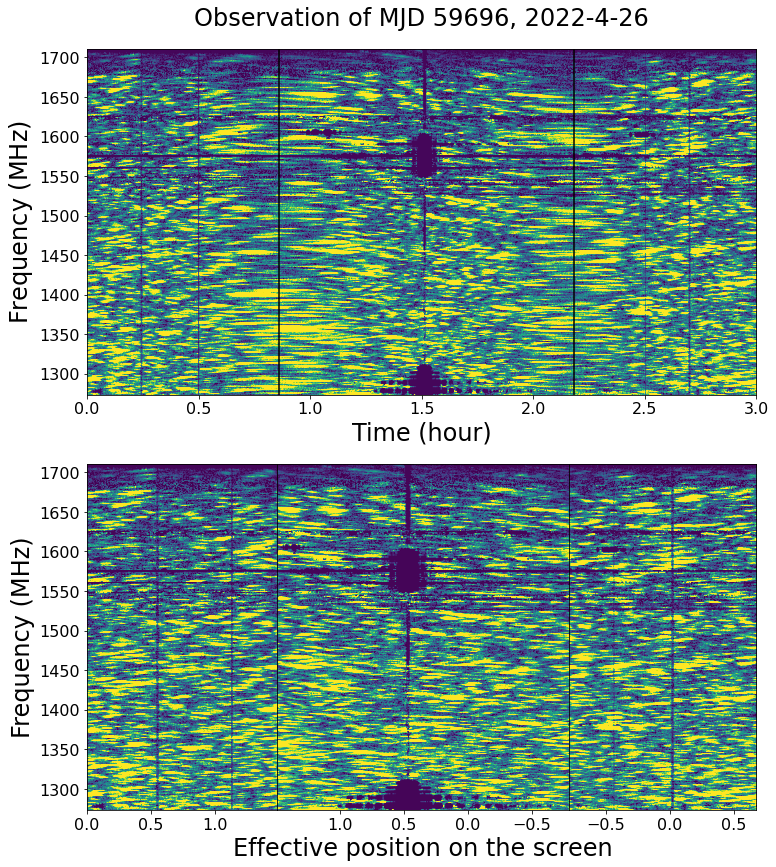

In [14]:
import matplotlib.gridspec as gridspec

def resamp_vis_combined(res_pos_u, res_dyn_u, fs_u, ds, ts, fs, std_fac=3., currentobs="", mjds=None, a_guess=None):
    relative_widths = [np.abs(x[0] - x[-1]).value for x in res_pos_u]
    total_width = sum(relative_widths)
    relative_widths = [width / total_width for width in relative_widths]

    fig = plt.figure(figsize=(sum(relative_widths) * 12, 14))

    # Set up a 2-row grid: 1 top row for main plot, 1 bottom row for res_dyn
    gs = gridspec.GridSpec(nrows=2, ncols=len(res_pos_u), height_ratios=[1, 1], 
                           width_ratios=relative_widths, hspace=0.2, wspace=0)

    # Top plot (main image across all columns)
    ax_top = fig.add_subplot(gs[0, :])
    im_top = ax_top.imshow(ds,
                           origin='lower', aspect='auto', 
                           extent=axis_extent(ts) + axis_extent(fs),
                           vmin=np.mean(ds) - std_fac * np.std(ds),
                           vmax=np.mean(ds) + std_fac * np.std(ds))
    ax_top.set_ylabel(rf"Frequency ({fs.unit.to_string('latex')})", fontsize=24)
    ax_top.set_xlabel(rf"Time (hour)", fontsize=24)
    ax_top.set_title(f'Observation of MJD {d2str(mjds,0)}, {currentobs}', fontsize=24, y=1.05)
    ax_top.tick_params(axis='both', which='major', labelsize=16)

    if a_guess is not None:
        for i in range(len(a_guess)):
            ax_top.axvline(x=a_guess[i], c='k')

    # Bottom subplots
    for i, (x, ax_pos) in enumerate(zip(res_pos_u, range(len(res_pos_u)))):
        ax = fig.add_subplot(gs[1, ax_pos])
        im = ax.imshow(res_dyn_u[i],
                       origin='lower', aspect='auto', 
                       extent=ext_find(res_pos_u[i], fs_u),
                       vmin=np.nanmean(res_dyn_u[0]) - std_fac * np.nanstd(res_dyn_u[0]),
                       vmax=np.nanmean(res_dyn_u[0]) + std_fac * np.nanstd(res_dyn_u[0]))

        ax.tick_params(axis='both', which='major', labelsize=16)
        if i == 0:
            ax.set_ylabel('Frequency (MHz)', fontsize=24)
        else:
            ax.set_yticks([])

        if i == len(res_pos_u) // 2:
            ax.set_xlabel('Effective position on the screen', fontsize=24)

#     plt.tight_layout()
    
    plt.show()
    
resamp_vis_combined(res_pos, res_dyn, fs, ds, ts, fs, std_fac=1, currentobs= currentobs, mjds=mjds, a_guess=a_guess)


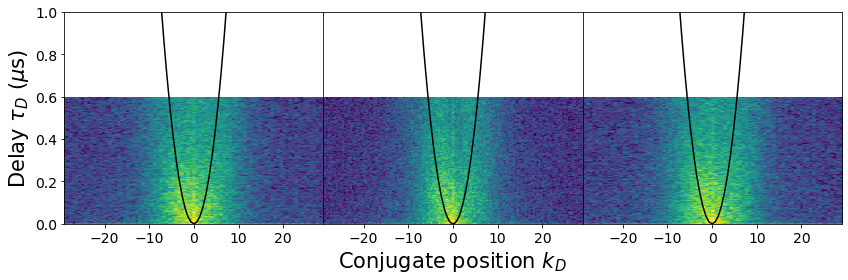

In [15]:
scalemin = 2e-7
scalemax = 1e-3
taulim = 1.
# tth_lim = 4
kdlimit = 29


#value of the resampled curvature (equivalent to Eq 29 times frequency squared)
#this is the measured value from table 1, or can also do 
# curv_constant = deff * const.c / 2 / B**2
curv_constant = 0.0427 * u.us * u.GHz**2
eta_2_use = (curv_constant / np.mean(fs)**2 )



plt.figure(figsize = (12,4))

#looping over the different regions
for i in range(len(res_dyn)):
    plt.subplot(1, len(res_dyn), i+1)
    plt.tight_layout()
    
    if i == 0:
        ylabels = 'Delay $\\tau_D$ ($\mu$s)'
        plt.ylabel(ylabels, fontsize = 21)
    else:
        ylabels = None
        plt.subplots_adjust(wspace=0, hspace=0.35)
        plt.yticks([])
    if i == 1:
        plt.xlabel('Conjugate position $k_D$ ', fontsize = 21)
        
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    #normalizing to the max of the observation (just for display purposes)
    kds, taus, css = res_kd[i], res_tau.to(u.us), res_CS[i]
    SS = np.abs(css)**2 
    SS /= np.max(SS)
    
    #plotting secondary spectra
    plt.imshow(SS, 
       norm=LogNorm(vmin= scalemin,vmax=scalemax ), 
       origin='lower',
       aspect='auto',
       
       extent=ext_find( kds, taus ))
    plt.ylim(0, taulim)
    plt.xlim((- kdlimit , kdlimit))
    
    #plot curvature
    plt.plot( kds, ((kds)**2 * eta_2_use).to(u.us), c = 'k')

plt.show()

